In [47]:
%cd research

/ssd/models/research


In [48]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import numpy as np
import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt_convert as trt
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore') 


In [113]:
def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

def input_ten(image_path):
    '''
    Converts image to tensor using Image Path to input into model.
    '''
    image_np = load_image_into_numpy_array(image_path)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]
    return input_tensor

def process_output(detections):
    '''
    Postprocesses output and displays image.
    '''
    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = load_image_into_numpy_array('test.jpg')
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')

# Helper function to benchmark the model
def benchmark(model, input_shape=(1, 640, 640, 3), nwarmup=20, nruns=100):
    '''
    It tests model inference time using a random tensor.
    '''
    input_data = tf.convert_to_tensor(np.random.normal(size=input_shape).astype(np.uint8))
    print("Warm up ...")

    for _ in range(nwarmup):
        features = model(input_data)
    print("Start timing ...")
    timings = []
    for i in range(1, nruns+1):
        start_time = time.time()
        output  = model(input_data)
        end_time = time.time()
        timings.append(end_time - start_time)
        if i%10==0:
            print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_shape)
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))
    return round(np.mean(timings)*1000,2)

In [50]:
TF_SAVED_MODEL_PATH = '/ssd/training_demo/exported_models/model_1/saved_model' #Finetuned Model Path
PBTXT_FILE = '/ssd/training_demo/annotations/label_map.pbtxt' #PBTXT file path that contains Classes name
TRT_EXPORTED_MODEL = '/ssd/training_demo/exported_models/detection_trt' #Directory to where TensorRT engines gets saved

In [51]:
category_index = label_map_util.create_category_index_from_labelmap(PBTXT_FILE,
                                                                    use_display_name=True)

## Inference Using Normal Tensorflow model

In [89]:
# Load Tensorflow model
detect_fn = tf.saved_model.load(TF_SAVED_MODEL_PATH)

#Inference
a = detect_fn(np.random.normal(size=(1, , 600, 3)).astype(np.float32))

In [117]:
# Benchmark Tensorflow Model
tenf = benchmark(detect_fn, input_shape=(1,1200,1200,3))

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 50.20 ms
Iteration 20/100, avg batch time 50.28 ms
Iteration 30/100, avg batch time 50.34 ms
Iteration 40/100, avg batch time 50.29 ms
Iteration 50/100, avg batch time 50.25 ms
Iteration 60/100, avg batch time 50.29 ms
Iteration 70/100, avg batch time 50.31 ms
Iteration 80/100, avg batch time 50.31 ms
Iteration 90/100, avg batch time 50.29 ms
Iteration 100/100, avg batch time 50.31 ms
Input shape: (1, 1200, 1200, 3)
Average batch time: 50.31 ms


## Creating TensorRT Optimized Model

In [52]:
from tensorflow.python.client import device_lib
# Checks if TensorRT compatible GPU is present
def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        if "compute capability" in str(line):
            compute_capability = float(line.physical_device_desc.split("compute capability: ")[-1])
            if compute_capability>=7.0:
                return True
    
print("Tensor Core GPU Present:", check_tensor_core_gpu_present())
tensor_core_gpu = check_tensor_core_gpu_present()

Tensor Core GPU Present: True


2021-12-06 00:00:57.953933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 46809 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5
2021-12-06 00:00:57.961352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 46809 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [ ]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP16,
                                                               max_workspace_size_bytes=8000000000)

converter = trt.TrtGraphConverterV2(input_saved_model_dir=TF_SAVED_MODEL_PATH,
                                    conversion_params=conversion_params)
converter.convert()
converter.save(TRT_EXPORTED_MODEL)
print('Done Converting to TF-TRT FP16')


## Inference from TensorRT Model:

In [63]:
#Load TensorRT Model
model = tf.saved_model.load(TRT_EXPORTED_MODEL)
func = model.signatures['serving_default']


In [84]:
#Sample image from internet
!wget -O test.jpg "https://health.clevelandclinic.org/wp-content/uploads/sites/3/2018/03/Polyp.png" 

#Convert Image to Tensor
samp = input_ten('test.jpg')

--2021-12-06 00:24:46--  https://health.clevelandclinic.org/wp-content/uploads/sites/3/2018/03/Polyp.png
Resolving health.clevelandclinic.org (health.clevelandclinic.org)... 35.185.75.237
Connecting to health.clevelandclinic.org (health.clevelandclinic.org)|35.185.75.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 514164 (502K) [image/png]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 502.11K  1.25MB/s    in 0.4s    

2021-12-06 00:24:47 (1.25 MB/s) - ‘test.jpg’ saved [514164/514164]



Done


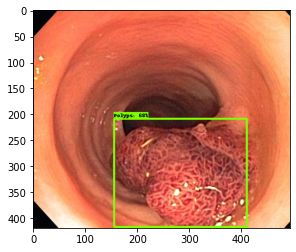

In [87]:
## Inference output from model
output = func(samp)
process_output(output)

In [116]:
# Benchmark TensorRT Model
trt = benchmark(func, input_shape=(1,1200,1200,3))

Warm up ...
Start timing ...
Iteration 10/100, avg batch time 21.26 ms
Iteration 20/100, avg batch time 21.36 ms
Iteration 30/100, avg batch time 21.36 ms
Iteration 40/100, avg batch time 21.23 ms
Iteration 50/100, avg batch time 21.16 ms
Iteration 60/100, avg batch time 21.08 ms
Iteration 70/100, avg batch time 21.02 ms
Iteration 80/100, avg batch time 20.99 ms
Iteration 90/100, avg batch time 20.96 ms
Iteration 100/100, avg batch time 20.91 ms
Input shape: (1, 1200, 1200, 3)
Average batch time: 20.91 ms


## Comparing

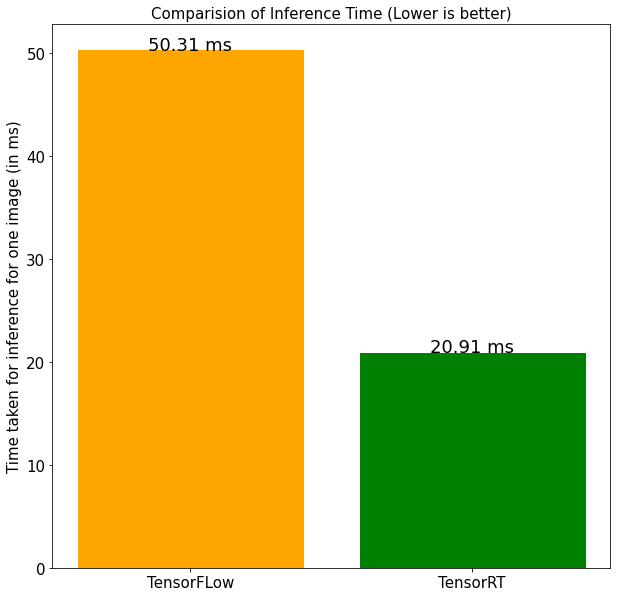

In [124]:
# Plotting Tensorflow vs TensorRT Inference Time plot.

fig = plt.figure(figsize = (10, 10))
y = [round(tenf,2),round(trt,2)]
plt.rcParams.update({'font.size': 15})
# creating the bar plot
barr = plt.bar(['TensorFLow','TensorRT'], y)
barr[0].set_color('orange')
barr[1].set_color('green')
plt.ylabel("Time taken for inference for one image (in ms)",fontdict=dict(fontsize=15))
plt.title("Comparision of Inference Time (Lower is better)",fontdict=dict(fontsize=15))
for index,data in enumerate(y):
    plt.text(x=index , y =data +0.03, s=f"{data} ms" ,ha='center', fontdict=dict(fontsize=18))
plt.show()